In [1]:
%matplotlib inline
import feather
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Read in mutation frequency trajectories for this replicate, which is actually replicate 0
data=feather.read_dataframe('../H2_0.2_OPT_0.5_mu_0.001.traj.rep1.feather')
data['scaled_time']=pd.Series(data.generation-pd.Series(np.array([10000.0]*len(data.index),dtype=np.float64)))
data['scaled_time'] /= pd.Series(np.array([1000.0]*len(data.index),dtype=np.float64))
#Add in a scaled time column

In [3]:
#Collect into groups
g=data.groupby([data.esize,data.origin,data.pos])

In [4]:
#Filter groups into new pd.DF based on fixed vs. lost, then re-group
fixations=g.filter(lambda x:x['freq'].max()==1.0 and x['origin'].max() >= 9000 and x['origin'].max() <=15000).groupby(['esize','origin','pos'])
losses=g.filter(lambda x:len(x['freq'])>=5 and x['freq'].max()>=0.1 and x['freq'].max()<1.0).groupby(['esize','origin','pos'])

In [56]:
#Read in the popstats
pstats=feather.read_dataframe('../H2_0.2_OPT_0.5_mu_0.001.popstats.feather')

In [57]:
#Convert generations into g/N, with time 0 = time of optimum shift
pstats['scaled_time']=pd.Series((pstats.generation-pd.Series(np.array([10000.0]*len(pstats.index),dtype=np.float64))))
pstats['scaled_time'] /= pd.Series(np.array([1000.0]*len(pstats.index),dtype=np.float64))

In [58]:
pstats.head()

,generation,rep,stat,value,scaled_time
0,1,0,VG,0.000000,-9.999
1,1,0,VE,0.016191,-9.999
2,1,0,leading_q,NaN,-9.999
3,1,0,leading_e,NaN,-9.999
4,1,0,max_expl,0.000000,-9.999


In [59]:
pstatsRep0=pstats.groupby(['rep']).filter(lambda x:x['rep'].max()==0) #Pull out data for replicate 0.  max() is a hack...

normal
3


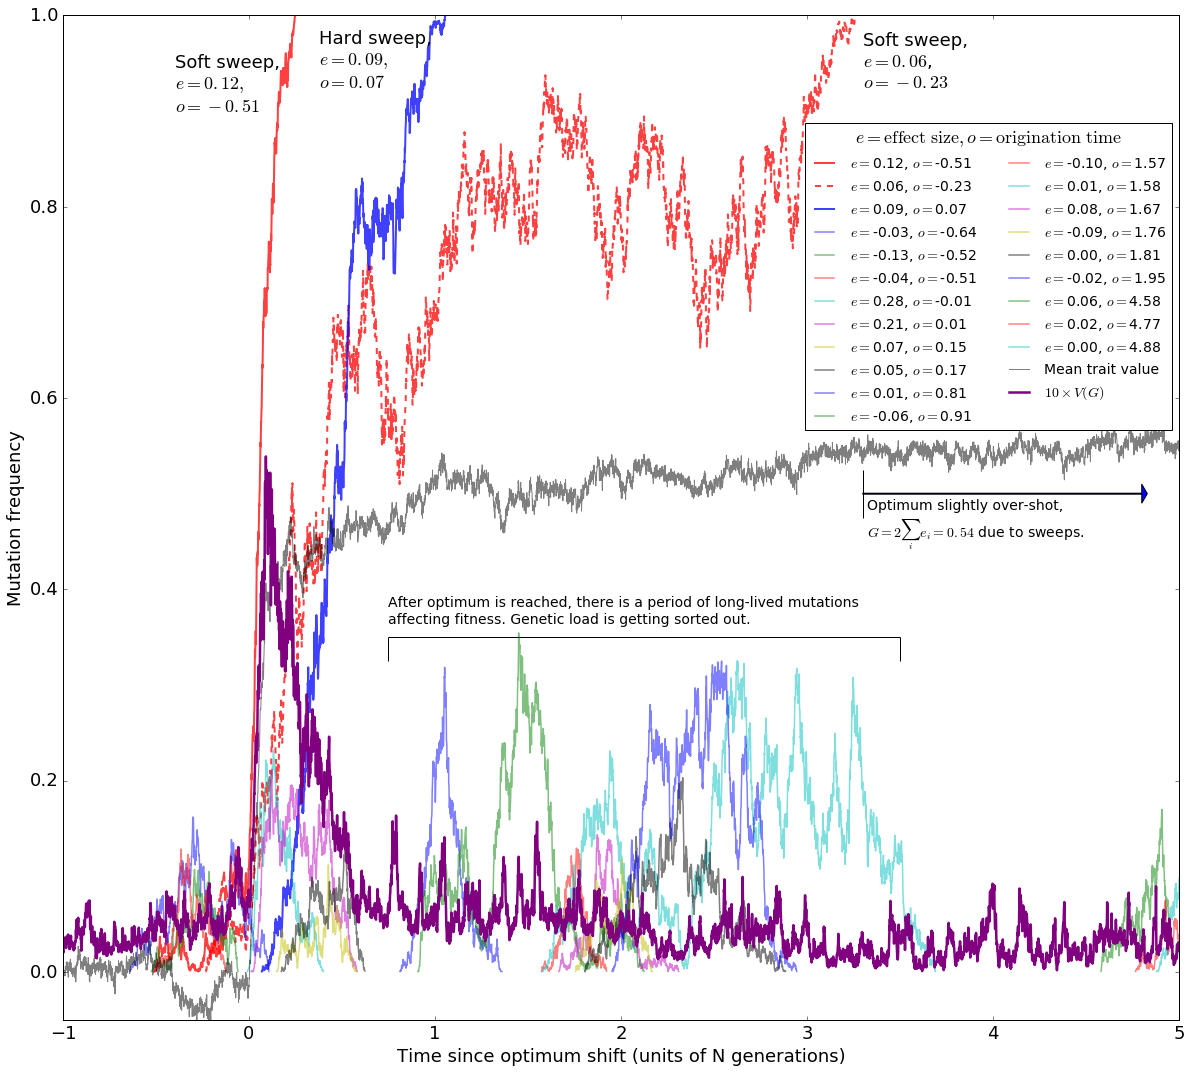

In [80]:
# matplotlib.rc('font', family='sans-serif') 
#matplotlib.rc('font', serif='Helvetica') 
#matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'legend.fontsize': 14})
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(20, 18)
plt.plot(dpi=300)

##SORT FIXATIONS BY ORIGIN TIME
FIXATIONS=[]
for i in fixations.groups:
    fix_i = fixations.get_group(i)
    FIXATIONS.append(fix_i)
FIXATIONS=sorted(FIXATIONS,key = lambda F : F.origin.min())
#plot fixations
FSTYLES=['solid','dashed','solid']  #hand-coded hack
FSTYLE=0
for fix_i in FIXATIONS:
    #fix_i=fixations.get_group(i)
    fix_color="red"
    fix_alpha=0.25
    fix_style=FSTYLES[FSTYLE]
    if fix_i.origin.min()>10000:
        fix_color='blue'
        fix_alpha=1.0
        fix_style='solid'
    else:
        FSTYLE+=1
    esize=fix_i.esize.mean()
    origin=fix_i.origin.mean()
    plt.plot(fix_i.scaled_time,fix_i.freq,color=fix_color,
             alpha=0.75,
             linestyle=fix_style,
             linewidth=2,
             label=r'$e = $'+'{0:.2f}'.format(esize)+
             r', $o = $'+'{0:0.2f}'.format((origin-1e4)/1e3))
    
#Now, deal with losses
#We will collect them into a list, for sorting
#I really wish I could just sort the groups...
LOSSES=[]
for i in losses.groups:
    losses_i=losses.get_group(i)
    if losses_i.origin.max() >= 9000 and losses_i.origin.max() < 15000:
        LOSSES.append(losses_i)
        
LOSSES=sorted(LOSSES,key = lambda LI: LI.origin.min()) #Sort base on origin time, .min is again a hack
for i in LOSSES:
    esize=i.esize.mean()
    origin=i.origin.mean()
    plt.plot(i.scaled_time,i.freq,
             linewidth=1.5,
             alpha=0.5,label=r'$e = $'+'{0:0.2f}'.format(esize)+r', $o = $'+'{0:0.2f}'.format((origin-1e4)/1e3))
    
#PLot mean trait value
plt.plot(pstatsRep0.scaled_time[pstatsRep0.stat=='tbar'],
         pstatsRep0.value[pstatsRep0.stat=='tbar'],
             color='black',alpha=0.5,label="Mean trait value")
#10xVG, so that it shows up
plt.plot(pstatsRep0.scaled_time[pstatsRep0.stat=='tbar'],
         10.0*pstatsRep0.value[pstatsRep0.stat=='VG'],
             color='purple',linestyle='solid',linewidth=2.5,alpha=1,label=r'$10 \times V(G)$')
plt.xlim(-1,5)
plt.ylim(-0.05,1)
plt.text(-0.4,0.9,'Soft sweep,\n'+r'$e = 0.12,$'+'\n'+r'$o = -0.51$')
plt.text(0.375,0.925,'Hard sweep,\n'+r'$e = 0.09,$'+'\n'+r'$o = 0.07$')
plt.text(3.3,0.925,'Soft sweep,\n'+r'$e = 0.06$,'+'\n'+r'$o = -0.23$')
plt.xlabel("Time since optimum shift (units of N generations)")
plt.ylabel("Mutation frequency")
plt.hlines(0.35,0.75,3.5)
plt.vlines(0.75,0.325,0.35)
plt.vlines(3.5,0.325,0.35)
plt.text(0.75,0.365,"After optimum is reached, "+
         "there is a period of long-lived mutations\naffecting fitness. "+
         "Genetic load is getting sorted out.",fontsize=14)
plt.vlines(3.3,0.475,0.525)
ax=plt.axes()
ax.arrow(3.3,0.5,1.5,0)
plt.legend(bbox_to_anchor=(1.0,0.9),ncol=2,title=r'$e = \mathrm{effect\ size}, o = \mathrm{origination\ time}$')
plt.text(3.325,0.445,"Optimum slightly over-shot,\n"+r'$G=2\sum_i e_i = 0.54$'+' due to sweeps.',fontsize=14)
plt.savefig("trajectories.pdf",bbox_inches='tight')

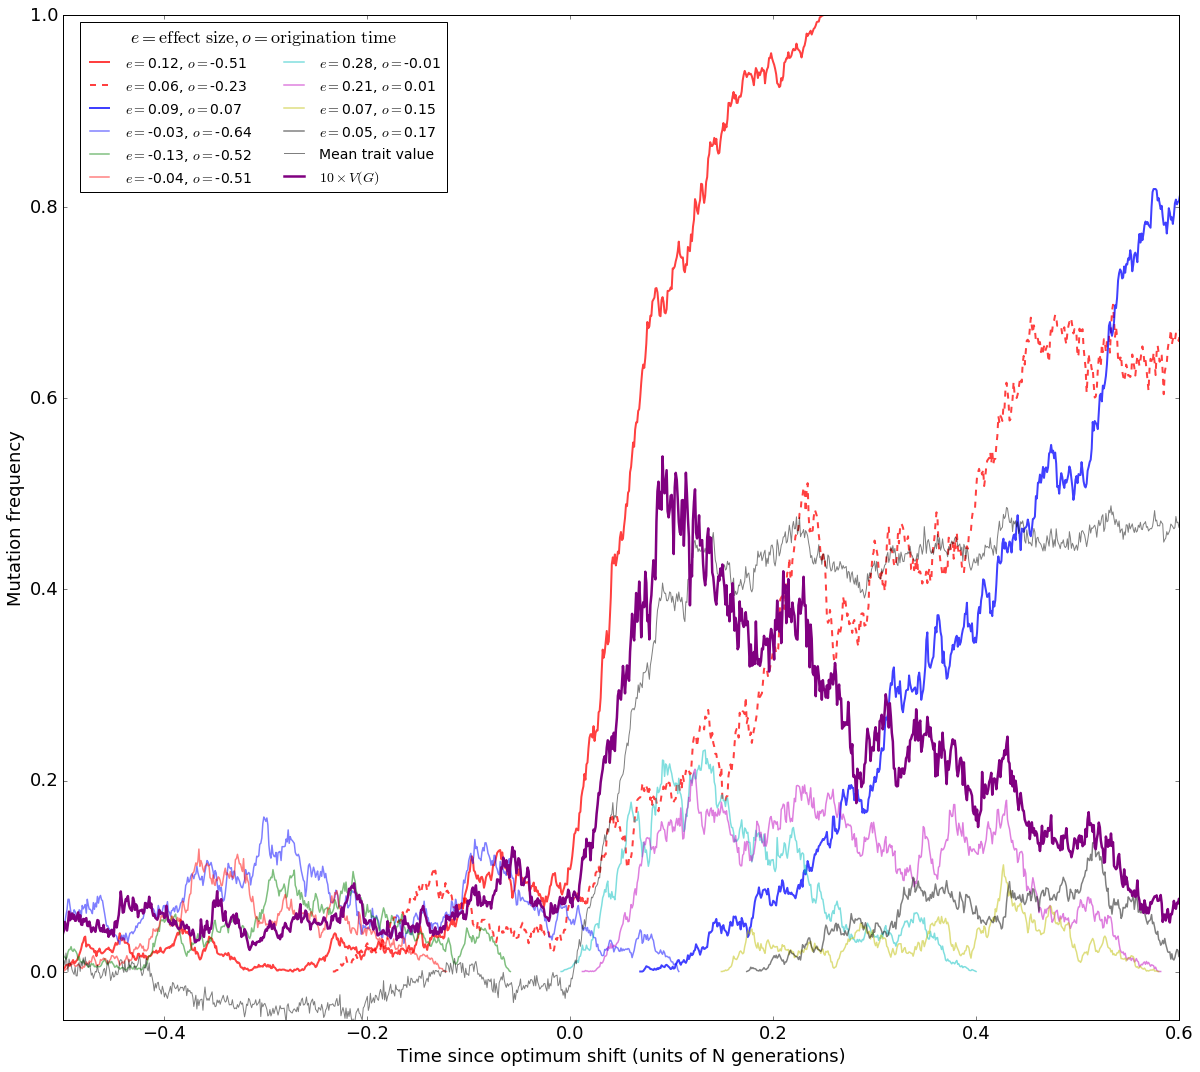

In [89]:
#Now, kinda lame, but let's do a zoom-in on the very early dynamics
# matplotlib.rc('font', family='sans-serif') 
#matplotlib.rc('font', serif='Helvetica') 
#matplotlib.rc('text', usetex='false') 
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(20, 18)
plt.plot(dpi=300)

##SORT FIXATIONS BY ORIGIN TIME
FIXATIONS=[]
for i in fixations.groups:
    fix_i = fixations.get_group(i)
    FIXATIONS.append(fix_i)
FIXATIONS=sorted(FIXATIONS,key = lambda F : F.origin.min())
#plot fixations
FSTYLES=['solid','dashed','solid']  #hand-coded hack
FSTYLE=0
for fix_i in FIXATIONS:
    #fix_i=fixations.get_group(i)
    fix_color="red"
    fix_alpha=0.25
    fix_style=FSTYLES[FSTYLE]
    if fix_i.origin.min()>10000:
        fix_color='blue'
        fix_alpha=1.0
        fix_style='solid'
    else:
        FSTYLE+=1
    esize=fix_i.esize.mean()
    origin=fix_i.origin.mean()
    plt.plot(fix_i.scaled_time,fix_i.freq,color=fix_color,
             alpha=0.75,
             linestyle=fix_style,
             linewidth=2,
             label=r'$e = $'+'{0:.2f}'.format(esize)+
             r', $o = $'+'{0:0.2f}'.format((origin-1e4)/1e3))
    
#Now, deal with losses
#We will collect them into a list, for sorting
#I really wish I could just sort the groups...
LOSSES=[]
for i in losses.groups:
    losses_i=losses.get_group(i)
    if losses_i.origin.max() >= 9000 and losses_i.origin.max() < 10500:
        LOSSES.append(losses_i)
        
LOSSES=sorted(LOSSES,key = lambda LI: LI.origin.min()) #Sort base on origin time, .min is again a hack
for i in LOSSES:
    esize=i.esize.mean()
    origin=i.origin.mean()
    plt.plot(i.scaled_time,i.freq,
             linewidth=1.5,
             alpha=0.5,label=r'$e = $'+'{0:0.2f}'.format(esize)+r', $o = $'+'{0:0.2f}'.format((origin-1e4)/1e3))
    
#PLot mean trait value
plt.plot(pstatsRep0.scaled_time[pstatsRep0.stat=='tbar'],
         pstatsRep0.value[pstatsRep0.stat=='tbar'],
             color='black',alpha=0.5,label="Mean trait value")
#10xVG, so that it shows up
plt.plot(pstatsRep0.scaled_time[pstatsRep0.stat=='tbar'],
         10.0*pstatsRep0.value[pstatsRep0.stat=='VG'],
             color='purple',linestyle='solid',linewidth=2.5,alpha=1,label=r'$10 \times V(G)$')
plt.xlim(-0.5,0.6)
plt.ylim(-0.05,1)
#plt.text(-0.4,0.9,'Soft sweep,\n'+r'$e = 0.12,$'+'\n'+r'$o = -0.51$')
#plt.text(0.375,0.925,'Hard sweep,\n'+r'$e = 0.09,$'+'\n'+r'$o = 0.07$')
#plt.text(3.3,0.925,'Soft sweep,\n'+r'$e = 0.06$,'+'\n'+r'$o = -0.23$')
plt.xlabel("Time since optimum shift (units of N generations)")
plt.ylabel("Mutation frequency")
#plt.hlines(0.35,0.75,3.5)
#plt.vlines(0.75,0.325,0.35)
#plt.vlines(3.5,0.325,0.35)
#plt.text(0.75,0.365,"After optimum is reached, "+
#         "there is a period of long-lived mutations\naffecting fitness. "+
#         "Genetic load is getting sorted out.",fontsize=14)
#plt.vlines(3.3,0.475,0.525)
#ax=plt.axes()
#ax.arrow(3.3,0.5,1.5,0)
plt.legend(bbox_to_anchor=(0.35,1.0),ncol=2,title=r'$e = \mathrm{effect\ size}, o = \mathrm{origination\ time}$')
#plt.text(3.325,0.445,"Optimum slightly over-shot,\n"+r'$G=2\sum_i e_i = 0.54$'+' due to sweeps.',fontsize=14)
#plt.savefig("trajectories.pdf",bbox_inches='tight')